This notebook contains the data analysis for arXiv:1901.09673, "The Minimum Environmental Perturbation Principle." The data comes from K. Rothhaupt, <i>Nature</i> <b>333</b>:660 (1988), and was converted to the accompanying Excel file 'rothhaupt.xlsx' using the WebPlotDigitizer (https://automeris.io/WebPlotDigitizer/).

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends import backend_pdf as bpdf
import matplotlib
import pickle
from scipy.optimize import brentq,curve_fit,least_squares
%matplotlib inline

# Fit the data

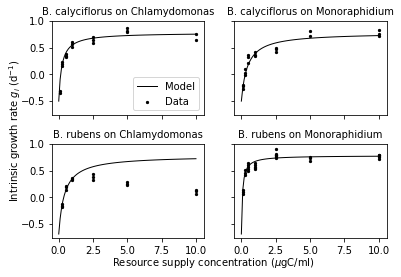

In [7]:
#Load growth rates, extracted from Figure 1
growth_rates = pd.read_excel('Rothhaupt.xlsx',header=[0,1])

#Load maximal clearance rates, copied from Table 1
conv = 24/1e3 #Convert to ml/animal/day
cRM = 10.5 * conv
cRC = 2.04 * conv
cCM = 8.78 * conv
cCC = 17.78 * conv

#Define monod curve for fitting
def monod(R,ewc,eK,gmax):
    return ewc*R/(1+(ewc*R/eK))-eK+gmax

#Make residuals, using measured clearance rates
def res(params):
    Delta = []
    
    eR,eC,KR,KC,gmax = params
    e = {'B. calyciflorus on Chlamydomonas':eC,
         'B. calyciflorus on Monoraphidium':eC,
         'B. rubens on Chlamydomonas':eR,
         'B. rubens on Monoraphidium':eR}
    K = {'B. calyciflorus on Chlamydomonas':KC,
         'B. calyciflorus on Monoraphidium':KC,
         'B. rubens on Chlamydomonas':KR,
         'B. rubens on Monoraphidium':KR}
    c = {'B. calyciflorus on Chlamydomonas':cCC,
         'B. calyciflorus on Monoraphidium':cCM,
         'B. rubens on Chlamydomonas':cRC,
         'B. rubens on Monoraphidium':cRM}
    
    for name in growth_rates.keys().levels[0]:
        data = growth_rates[name].dropna()
        if name == 'B. rubens on Chlamydomonas':
            data=data.iloc[:9]
        Delta=Delta+list(data['Y']-monod(data['X'],e[name]*c[name],e[name]*K[name],gmax))
        
    return np.asarray(Delta)

#Initial guesses for nonlinear least squares
params0 = 1,0.26,1.5,1.5,0.78
#Perform nonlinear least squares
out = least_squares(res,params0)
eR,eC,KR,KC,gmax = out.x
e = {'B. calyciflorus on Chlamydomonas':eC,
         'B. calyciflorus on Monoraphidium':eC,
         'B. rubens on Chlamydomonas':eR,
         'B. rubens on Monoraphidium':eR}
K = {'B. calyciflorus on Chlamydomonas':KC,
         'B. calyciflorus on Monoraphidium':KC,
         'B. rubens on Chlamydomonas':KR,
         'B. rubens on Monoraphidium':KR}
c = {'B. calyciflorus on Chlamydomonas':cCC,
         'B. calyciflorus on Monoraphidium':cCM,
         'B. rubens on Chlamydomonas':cRC,
         'B. rubens on Monoraphidium':cRM}

R = np.linspace(0,10,100)
k=0
fig,ax=plt.subplots(2,2,sharex=True,sharey=True)
fig.subplots_adjust(hspace=0.3)
ax = ax.reshape(-1)
for name in growth_rates.keys().levels[0]:
    data = growth_rates[name].dropna()
    ax[k].scatter(data['X'],data['Y'],c='k',s=5,label='Data')
    ax[k].plot(R,monod(R,e[name]*c[name],e[name]*K[name],gmax),'k',label='Model',lw=1)
    ax[k].set_title(name,fontsize=10)
    k+=1
ax[0].legend()
fig.text(0.04, 0.5, r'Intrinsic growth rate $g_i$ (d$^{-1}$)', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.04, r'Resource supply concentration ($\mu$gC/ml)', ha='center', va='center')
pdf = bpdf.PdfPages('GrowthCurves.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

In [18]:
c

{'B. calyciflorus on Chlamydomonas': 0.42672000000000004,
 'B. calyciflorus on Monoraphidium': 0.21072,
 'B. rubens on Chlamydomonas': 0.048960000000000004,
 'B. rubens on Monoraphidium': 0.252}

In [19]:
e

{'B. calyciflorus on Chlamydomonas': 13.824960763646912,
 'B. calyciflorus on Monoraphidium': 13.824960763646912,
 'B. rubens on Chlamydomonas': 72.83628750741282,
 'B. rubens on Monoraphidium': 72.83628750741282}

In [14]:
K

{'B. calyciflorus on Chlamydomonas': 0.09271853173216153,
 'B. calyciflorus on Monoraphidium': 0.09271853173216153,
 'B. rubens on Chlamydomonas': 0.020173268114733644,
 'B. rubens on Monoraphidium': 0.020173268114733644}

In [15]:
m = {}
for item in e:
    m[item] = K[item] - gmax/e[item]
m

{'B. calyciflorus on Chlamydomonas': 0.036342444479916865,
 'B. calyciflorus on Monoraphidium': 0.036342444479916865,
 'B. rubens on Chlamydomonas': 0.00947259649976569,
 'B. rubens on Monoraphidium': 0.00947259649976569}

# Compute environmental perturbations

In [5]:
d_min_0 = []
d_min_1 = []
d_coex = []
intercepts0 = {}
slopes0 = {}
R = np.linspace(1e-4,1.5,1000)

def d_ext(R0,R):
    return ((R0[0]*np.log(R0[0]/R[0]) - (R0[0] - R[0]))+
            (R0[1]*np.log(R0[1]/R[1]) - (R0[1] - R[1])))

#Load list of competition outcomes:
#0: B. Rubens wins
#1: B. Caly wins
#2: Coexistence
win_list = np.asarray([1,2,0,0,0,0,1,2,2,2,0,0])

for D in [0.2,0.45]:
    #Find Rstar for each species-resource pair
    Rstar = {}
    for name in growth_rates.keys().levels[0]:
        def deltag(R):
            return monod(R,e[name]*c[name],e[name]*K[name],gmax)-D
        Rstar[name] = brentq(deltag,0,10)
    print(Rstar)
    
    #Find intersection of ZNGI's
    intercepts = [Rstar['B. rubens on Chlamydomonas'],Rstar['B. calyciflorus on Chlamydomonas']]
    slopes = [Rstar['B. rubens on Chlamydomonas']/Rstar['B. rubens on Monoraphidium'],
              Rstar['B. calyciflorus on Chlamydomonas']/Rstar['B. calyciflorus on Monoraphidium']]
    Rcoex = [(intercepts[0]-intercepts[1])/(slopes[0]-slopes[1]),
             (slopes[0]*intercepts[1]-slopes[1]*intercepts[0])/(slopes[0]-slopes[1])]
    print(Rcoex)

    #Save ZNGI's
    Rvec0 = np.vstack((R,intercepts[0]-slopes[0]*R)).T
    Rvec1 = np.vstack((R,intercepts[1]-slopes[1]*R)).T
    Rvec0 = Rvec0[Rvec0[:,1]>1e-4,:]
    Rvec1 = Rvec1[Rvec1[:,1]>1e-4,:]

    #Load supply vectors
    if D == 0.2:
        R0_list = pd.read_excel('R0list.xlsx',header=[0,1])['D20'].values
    elif D == 0.45:
        R0_list = pd.read_excel('R0list.xlsx',header=[0,1])['D45'].values

    for R0 in R0_list:
        d_min_0.append(np.min(np.asarray([d_ext(R0,Rvec0[k,:]) for k in range (len(Rvec0))])))
        d_min_1.append(np.min(np.asarray([d_ext(R0,Rvec1[k,:]) for k in range (len(Rvec1))])))
        d_coex.append(d_ext(R0,Rcoex))
        
dlist = np.vstack((d_min_0,d_min_1,d_coex)).T

{'B. calyciflorus on Chlamydomonas': 0.26342196486150515, 'B. calyciflorus on Monoraphidium': 0.5334444800954007, 'B. rubens on Chlamydomonas': 0.632883053618339, 'B. rubens on Monoraphidium': 0.12296013613156286}
[0.07939857993134705, 0.22421389220699342]
{'B. calyciflorus on Chlamydomonas': 0.6282579984807669, 'B. calyciflorus on Monoraphidium': 1.2722582247138996, 'B. rubens on Chlamydomonas': 1.4259368324241661, 'B. rubens on Monoraphidium': 0.2770391560138382}
[0.17142418669719092, 0.5436064597180371]


# Make contour plot

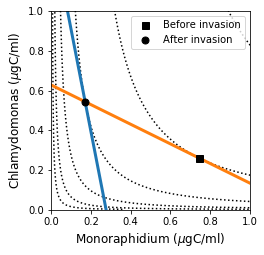

In [6]:
#Plot ZNGI's
colors = sns.color_palette()
fig,ax=plt.subplots(figsize=(4,4))
fig.subplots_adjust(left=0.2,bottom=0.19)
ax.axis('square')
ax.plot(Rvec0[:,0],Rvec0[:,1],color=colors[0],lw=3)
ax.plot(Rvec1[:,0],Rvec1[:,1],color=colors[1],lw=3)
    
#Make contours
m=3
delta = 0.0025
Rmax = 1.5
R1 = np.arange(0, Rmax, delta)
R2 = np.arange(0, Rmax, delta)
R1 = R1[1:]
R2 = R2[1:]
R1_mat, R2_mat = np.meshgrid(R1,R2)
if D == 0.2:
    d_after = dlist[m,win_list[m]]
    d_before = d_min_1[m]
else:
    d_after = dlist[m+6,win_list[m+6]]
    d_before = d_min_1[m+6]
Delta = d_after - d_before
d_mat = np.asarray([[d_ext(R0_list[m],[R1_mat[j,k],R2_mat[j,k]]) for k in range(len(R1_mat.T))] for j in range(len(R1_mat))])
CS = ax.contour(R1_mat, R2_mat, d_mat, np.arange(-1,5)*Delta+d_before,alpha=1,colors='k',linestyles='dotted')
R_before = Rvec1[np.argmin(np.asarray([d_ext(R0_list[m],Rvec1[k,:]) for k in range (len(Rvec1))]))]
ax.plot([R_before[0]],[R_before[1]],'sk',ms=7,label='Before invasion')
ax.plot([Rcoex[0]],[Rcoex[1]],'ok',ms=7,label='After invasion')
ax.legend()
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.set_xlabel(r'Monoraphidium ($\mu$gC/ml)',fontsize=12)
ax.set_ylabel(r'Chlamydomonas ($\mu$gC/ml)',fontsize=12)
pdf = bpdf.PdfPages('Roth_example.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

# Make bar plot

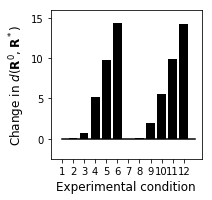

In [24]:
fig,ax=plt.subplots(figsize=(3,3))
fig.subplots_adjust(left=0.2,bottom=0.19)
d_before = np.asarray(d_min_1)
d_after = dlist[np.arange(len(dlist),dtype=int),win_list]
ax.bar(range(1,len(d_after)+1),d_after-d_before,color='k')
ax.plot([1,13],[0,0],'k')
ax.set_xticks(range(1,len(d_after)+1))
ax.set_ylabel(r'Change in $d(\mathbf{R}^0,\mathbf{R}^*)$',fontsize=12)
ax.set_xlabel('Experimental condition',fontsize=12)
ax.set_ylim((-2.5,16))
pdf = bpdf.PdfPages('Roth_pert.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()